<a href="https://colab.research.google.com/github/Nai5lf/Projects/blob/main/Train_delay_prediction(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **Train Delay Prediction**



# **1. Introduction**

---

Public transportation is a $74 billion industry that employs more than 436,000 people in the United States alone. Millions of individuals, families and even businesses depend on public transportation in their daily lives. It connects them to everywhere they need to go. With the busy lifestyle in cities these days, trains are a safe, clean and reliable transit service and serve as a big part of the transportation sector. With thousands of trains running everyday a slight delay affects and sometimes has a major impact on people's lives and businesses. Therefore government and transportation authorities are constantly striving to minimize delays and inefficiencies in train schedules.

The aim of this research is to predict train delays and provide insights on specific lines or trains. This can eventually help with further studies conducted on those specific lines to identify if the number of trains needs to be increased or specific upgrades might be needed for a specific line to increase efficiency.

The dataset used includes data on the New Jersey (NJ) Transit rail performance, the second largest commuter rail network in the United States by ridership. The dataset covers the performance of nearly every train trip on the NJ Transit rail network in a month, it has variables like train IDs, from, to, actual arrival time and 9 other variables. The data comes from [Kaggle](https://www.kaggle.com/pranavbadami/nj-transit-amtrak-nec-performance?select=2018_03.csv) and contains 243,028 observations and 13 variables.

# **2. Exploratory data analysis**

---

## **2.1 Imports and Dataframe Load**

In [ ]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split 
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.metrics import  classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from google.colab import drive 
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

# creating a dataframe called njt_1803 with the data for th NJ Transit
njt_1803 = pd.read_csv('/content/drive/MyDrive/Thinkful_data_science_bootcamp/Module(38): Final Capstone/2018_03.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Now that the dataset is loaded into the DataFrame `njt_1803` as shown below, it is now time to begin EDA. The first step is data cleaning**

In [ ]:
njt_1803.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256508 entries, 0 to 256507
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            256508 non-null  object 
 1   train_id        256508 non-null  object 
 2   stop_sequence   243028 non-null  float64
 3   from            256508 non-null  object 
 4   from_id         256508 non-null  int64  
 5   to              256508 non-null  object 
 6   to_id           256508 non-null  int64  
 7   scheduled_time  243028 non-null  object 
 8   actual_time     256508 non-null  object 
 9   delay_minutes   243028 non-null  float64
 10  status          256508 non-null  object 
 11  line            256508 non-null  object 
 12  type            256508 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 25.4+ MB


## **2.2 Data cleaning**

In [ ]:
# exploring the data and looking at the first 5 rows
njt_1803.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2018-03-01,3805,1.0,New York Penn Station,105,New York Penn Station,105,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit
1,2018-03-01,3805,2.0,New York Penn Station,105,Secaucus Upper Lvl,38187,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187,Newark Penn Station,107,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit
3,2018-03-01,3805,4.0,Newark Penn Station,107,Newark Airport,37953,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit
4,2018-03-01,3805,5.0,Newark Airport,37953,North Elizabeth,109,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit


In [ ]:
# looking at the last 5 rows
njt_1803.tail()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
256503,2018-03-31,0534,2.0,Bay Street,14,Glen Ridge,50,2018-03-31 19:02:00,2018-03-31 19:05:07,3.116667,departed,Montclair-Boonton,NJ Transit
256504,2018-03-31,0534,3.0,Glen Ridge,50,Bloomfield,19,2018-03-31 19:05:00,2018-03-31 19:08:06,3.100000,departed,Montclair-Boonton,NJ Transit
256505,2018-03-31,0534,4.0,Bloomfield,19,Watsessing Avenue,154,2018-03-31 19:07:00,2018-03-31 19:10:11,3.183333,departed,Montclair-Boonton,NJ Transit
256506,2018-03-31,0534,5.0,Watsessing Avenue,154,Newark Broad Street,106,2018-03-31 19:13:00,2018-03-31 19:21:02,8.033333,departed,Montclair-Boonton,NJ Transit
256507,2018-03-31,0534,6.0,Newark Broad Street,106,Hoboken,63,2018-03-31 19:38:00,2018-03-31 19:37:00,0.000000,estimated,Montclair-Boonton,NJ Transit


In [ ]:
njt_1803.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256508 entries, 0 to 256507
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            256508 non-null  object 
 1   train_id        256508 non-null  object 
 2   stop_sequence   243028 non-null  float64
 3   from            256508 non-null  object 
 4   from_id         256508 non-null  int64  
 5   to              256508 non-null  object 
 6   to_id           256508 non-null  int64  
 7   scheduled_time  243028 non-null  object 
 8   actual_time     256508 non-null  object 
 9   delay_minutes   243028 non-null  float64
 10  status          256508 non-null  object 
 11  line            256508 non-null  object 
 12  type            256508 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 25.4+ MB


In [ ]:
# making sure there are no blanks, '?' or '--' and if there are, they will converted to NaN
njt_1803.replace({'?': np.nan, '--': np.nan, ' ': np.nan}, inplace=True)

In [ ]:
# checking for Nans
njt_1803.isna().sum()

date                  0
train_id              0
stop_sequence     13480
from                  0
from_id               0
to                    0
to_id                 0
scheduled_time    13480
actual_time           0
delay_minutes     13480
status                0
line                  0
type                  0
dtype: int64

In [ ]:
# since we are looking for late trains I will drop the missing data instead of replacing them with the mean
njt_1803_filtered = njt_1803.dropna()

In [ ]:
# making sure the missing data was dropped
njt_1803_filtered.isna().sum()

date              0
train_id          0
stop_sequence     0
from              0
from_id           0
to                0
to_id             0
scheduled_time    0
actual_time       0
delay_minutes     0
status            0
line              0
type              0
dtype: int64

## **2.3 Data Exploration**

In [ ]:
# since our target feature is lateness of trains, we will create a column 'delay_status' that indicates True if a train is more than 15 minutes late
njt_1803_filtered.loc[njt_1803_filtered['delay_minutes'] >= 15, 'delay_status'] = 'Late'
njt_1803_filtered.loc[njt_1803_filtered['delay_minutes'] < 15, 'delay_status'] = 'On-time'
njt_1803_filtered.info()
njt_1803_filtered.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243028 entries, 0 to 256507
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            243028 non-null  object 
 1   train_id        243028 non-null  object 
 2   stop_sequence   243028 non-null  float64
 3   from            243028 non-null  object 
 4   from_id         243028 non-null  int64  
 5   to              243028 non-null  object 
 6   to_id           243028 non-null  int64  
 7   scheduled_time  243028 non-null  object 
 8   actual_time     243028 non-null  object 
 9   delay_minutes   243028 non-null  float64
 10  status          243028 non-null  object 
 11  line            243028 non-null  object 
 12  type            243028 non-null  object 
 13  delay_status    243028 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 27.8+ MB


,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type,delay_status
0,2018-03-01,3805,1.0,New York Penn Station,105,New York Penn Station,105,2018-03-02 01:22:00,2018-03-02 01:21:05,0.000000,departed,Northeast Corrdr,NJ Transit,On-time
1,2018-03-01,3805,2.0,New York Penn Station,105,Secaucus Upper Lvl,38187,2018-03-02 01:31:00,2018-03-02 01:31:08,0.133333,departed,Northeast Corrdr,NJ Transit,On-time
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,38187,Newark Penn Station,107,2018-03-02 01:40:00,2018-03-02 01:40:07,0.116667,departed,Northeast Corrdr,NJ Transit,On-time
3,2018-03-01,3805,4.0,Newark Penn Station,107,Newark Airport,37953,2018-03-02 01:45:00,2018-03-02 01:45:10,0.166667,departed,Northeast Corrdr,NJ Transit,On-time
4,2018-03-01,3805,5.0,Newark Airport,37953,North Elizabeth,109,2018-03-02 01:49:00,2018-03-02 01:49:10,0.166667,departed,Northeast Corrdr,NJ Transit,On-time


In [ ]:
# descriptive statistics (continuous variables)
njt_1803_filtered.describe()

,stop_sequence,from_id,to_id,delay_minutes
count,243028.000000,243028.000000,243028.000000,243028.000000
mean,7.981661,4260.552570,4270.296702,3.548316
std,5.074539,11846.526878,11856.815012,6.680843
min,1.000000,1.000000,1.000000,0.000000
25%,4.000000,57.000000,57.000000,0.233333
50%,7.000000,103.000000,103.000000,2.100000
75%,11.000000,136.000000,136.000000,4.116667
max,26.000000,43599.000000,43599.000000,111.183333


**We can tell from the mean of the *delay_minutes* column shown above that the average delay is approximately 3.55 minutes. There seems to be a maximum delay of roughly 111.2 minutes which might be outlier(s) due to emergencies or other rare incidents. Anyway, we will be looking for outliers next after visulasing the data.**

In [ ]:
# descriptive statistics (categorical variables)
njt_1803_filtered.describe(include='O')

,date,train_id,from,to,scheduled_time,actual_time,status,line,type,delay_status
count,243028,243028,243028,243028,243028,243028,243028,243028,243028,243028
unique,31,1319,165,165,39408,171504,3,11,1,2
top,2018-03-30,1085,New York Penn Station,New York Penn Station,2018-03-15 18:42:00,2018-03-06 23:55:30,departed,Northeast Corrdr,NJ Transit,On-time
freq,9844,520,7984,8086,20,41,217553,37663,243028,234463


In [ ]:
# printing all columns
columns = njt_1803_filtered.columns
print(columns)

Index(['date', 'train_id', 'stop_sequence', 'from', 'from_id', 'to', 'to_id',
       'scheduled_time', 'actual_time', 'delay_minutes', 'status', 'line',
       'type', 'delay_status'],
      dtype='object')


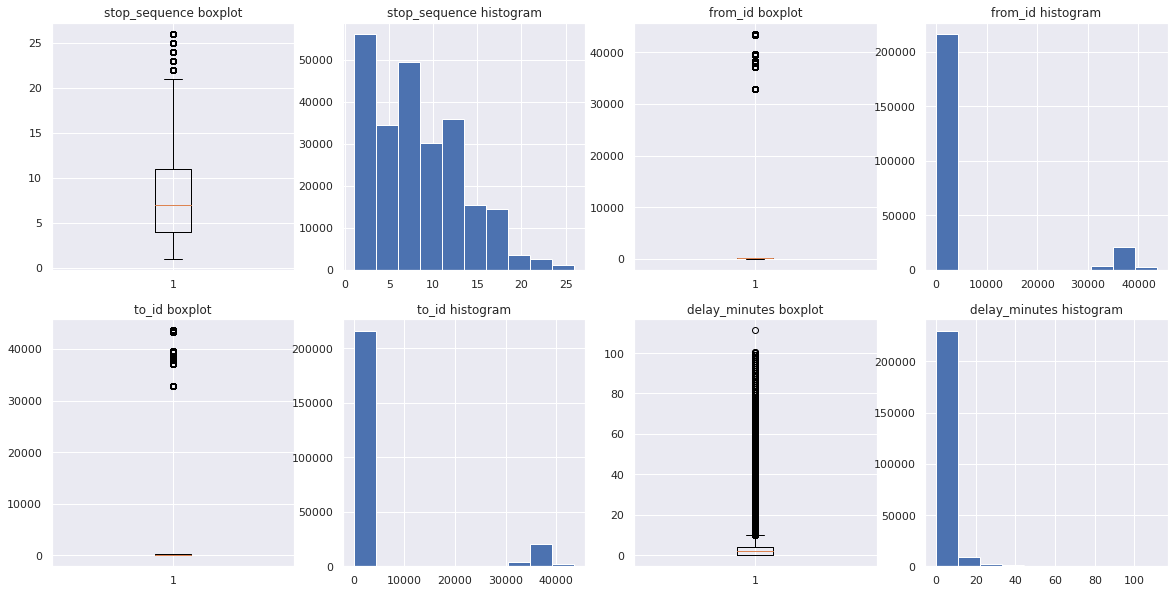

In [ ]:
# plotting continuous variables (boxplots and histograms) 
# checking for outliers visualy on the boxplots
cont_vars = ['stop_sequence', 'from_id', 'to_id', 'delay_minutes']

plt.figure(figsize=(20,10))

i = 0
for column in cont_vars:
    i += 1
    plt.subplot(2, 4, i)
    plt.boxplot(njt_1803_filtered[column])
    plt.title('{} boxplot'.format(column))
    i += 1
    plt.subplot(2, 4, i)
    plt.hist(njt_1803_filtered[column])
    plt.title('{} histogram'.format(column))
plt.show()

In [ ]:
# finding outliers
for column in cont_vars:
    print(column)
    q75, q25 = np.percentile(njt_1803_filtered[column], [75, 25])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    outlier_count = len(np.where((njt_1803_filtered[column] > max_val) | (njt_1803_filtered[column] < min_val))[0])
    outlier_percent = round(outlier_count/len(njt_1803_filtered[column])*100, 2)
    print('Number of outliers: {}'.format(outlier_count))
    print('Percent of data that is outlier: {}%'.format(outlier_percent))
    print(40*'-')

stop_sequence
Number of outliers: 2535
Percent of data that is outlier: 1.04%
----------------------------------------
from_id
Number of outliers: 26945
Percent of data that is outlier: 11.09%
----------------------------------------
to_id
Number of outliers: 27016
Percent of data that is outlier: 11.12%
----------------------------------------
delay_minutes
Number of outliers: 16408
Percent of data that is outlier: 6.75%
----------------------------------------


**There seems to be outliers but taking a closer look at the delay_minutes boxplot I can see that all the outliers there are late trains 10 minutes and more. I will keep them in this case since this is connected to train delays.**

On-time    234463
Late         8565
Name: delay_status, dtype: int64


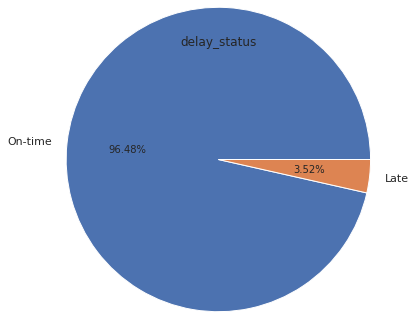

In [ ]:
# first we'll plot 'delay_status'
njt_1803_filtered['delay_status'].value_counts().plot(kind='pie',title='delay_status', radius= 1.75, autopct='%.2f%%')
print(njt_1803_filtered['delay_status'].value_counts())

**This is an imbalaced dataset as the target variable `delay_status` has 2 imbalanced classes. 8,565 Late cases and 234,463 on-time. I will deal with this further on using resampling.**

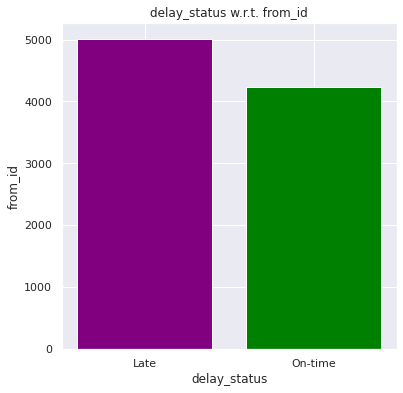

In [ ]:
# target variable 'delay_status' w.r.t. 'from_id'
plt.figure(figsize=(6,6))
plt.bar(njt_1803_filtered.groupby('delay_status')['delay_status'].count().index,njt_1803_filtered.groupby('delay_status')['from_id'].mean(), color=['purple', 'green'])
plt.xlabel('delay_status',fontsize=12)
plt.ylabel('from_id',fontsize=12)
plt.title('delay_status w.r.t. from_id')
plt.show()

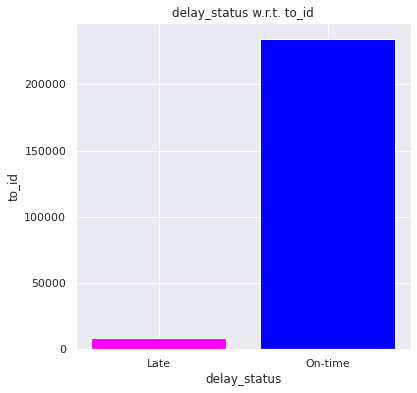

In [ ]:
# target variable 'delay_status' w.r.t. 'to_id'
plt.figure(figsize=(6,6))
plt.bar(njt_1803_filtered.groupby('delay_status')['delay_status'].count().index,njt_1803_filtered.groupby('delay_status')['train_id'].count(), color=['magenta', 'blue'])
plt.xlabel('delay_status',fontsize=12)
plt.ylabel('to_id',fontsize=12)
plt.title('delay_status w.r.t. to_id')
plt.show()

In [ ]:
njt_1803_filtered.groupby('delay_status').describe().T

delay_status                 Late        On-time
stop_sequence count   8565.000000  234463.000000
              mean       9.372329       7.930859
              std        4.892154       5.073877
              min        1.000000       1.000000
              25%        6.000000       4.000000
              50%        9.000000       7.000000
              75%       13.000000      11.000000
              max       26.000000      26.000000
from_id       count   8565.000000  234463.000000
              mean    5014.175131    4233.022524
              std    12693.392630   11813.560208
              min        1.000000       1.000000
              25%       63.000000      57.000000
              50%      105.000000     103.000000
              75%      137.000000     136.000000
              max    43599.000000   43599.000000
to_id         count   8565.000000  234463.000000
              mean    5187.765207    4236.781317
              std    12868.082045   11816.916174
              min        1.000000       1.000000
              25%       60.000000      57.000000
              50%      105.000000     103.000000
              75%      139.000000     136.000000
              max    43599.000000   43599.000000
delay_minutes count   8565.000000  234463.000000
              mean      29.833831       2.588098
              std       18.401442       2.781003
              min       15.000000       0.000000
              25%       17.216667       0.216667
              50%       22.200000       2.066667
              75%       35.100000       4.000000
              max      111.183333      14.716667

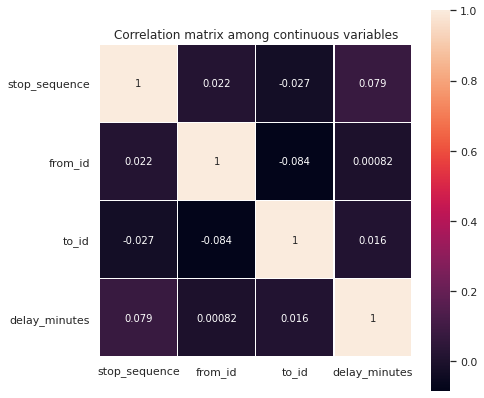

In [ ]:
# correlation heatmap for the cont. varaiables
sns.set()
cormat = njt_1803_filtered.corr()
plt.figure(figsize=(7,7))
sns.heatmap(cormat, square=True, annot=True, linewidths=.5)
plt.title('Correlation matrix among continuous variables')
plt.show()

In [ ]:
# showing categorical variables and their count
cat_vars = njt_1803_filtered.select_dtypes(['object']).columns
print(cat_vars)
print("The number of non-numerical columns is {}".format(len(cat_vars)))

Index(['date', 'train_id', 'from', 'to', 'scheduled_time', 'actual_time',
       'status', 'line', 'type', 'delay_status'],
      dtype='object')
The number of non-numerical columns is 10


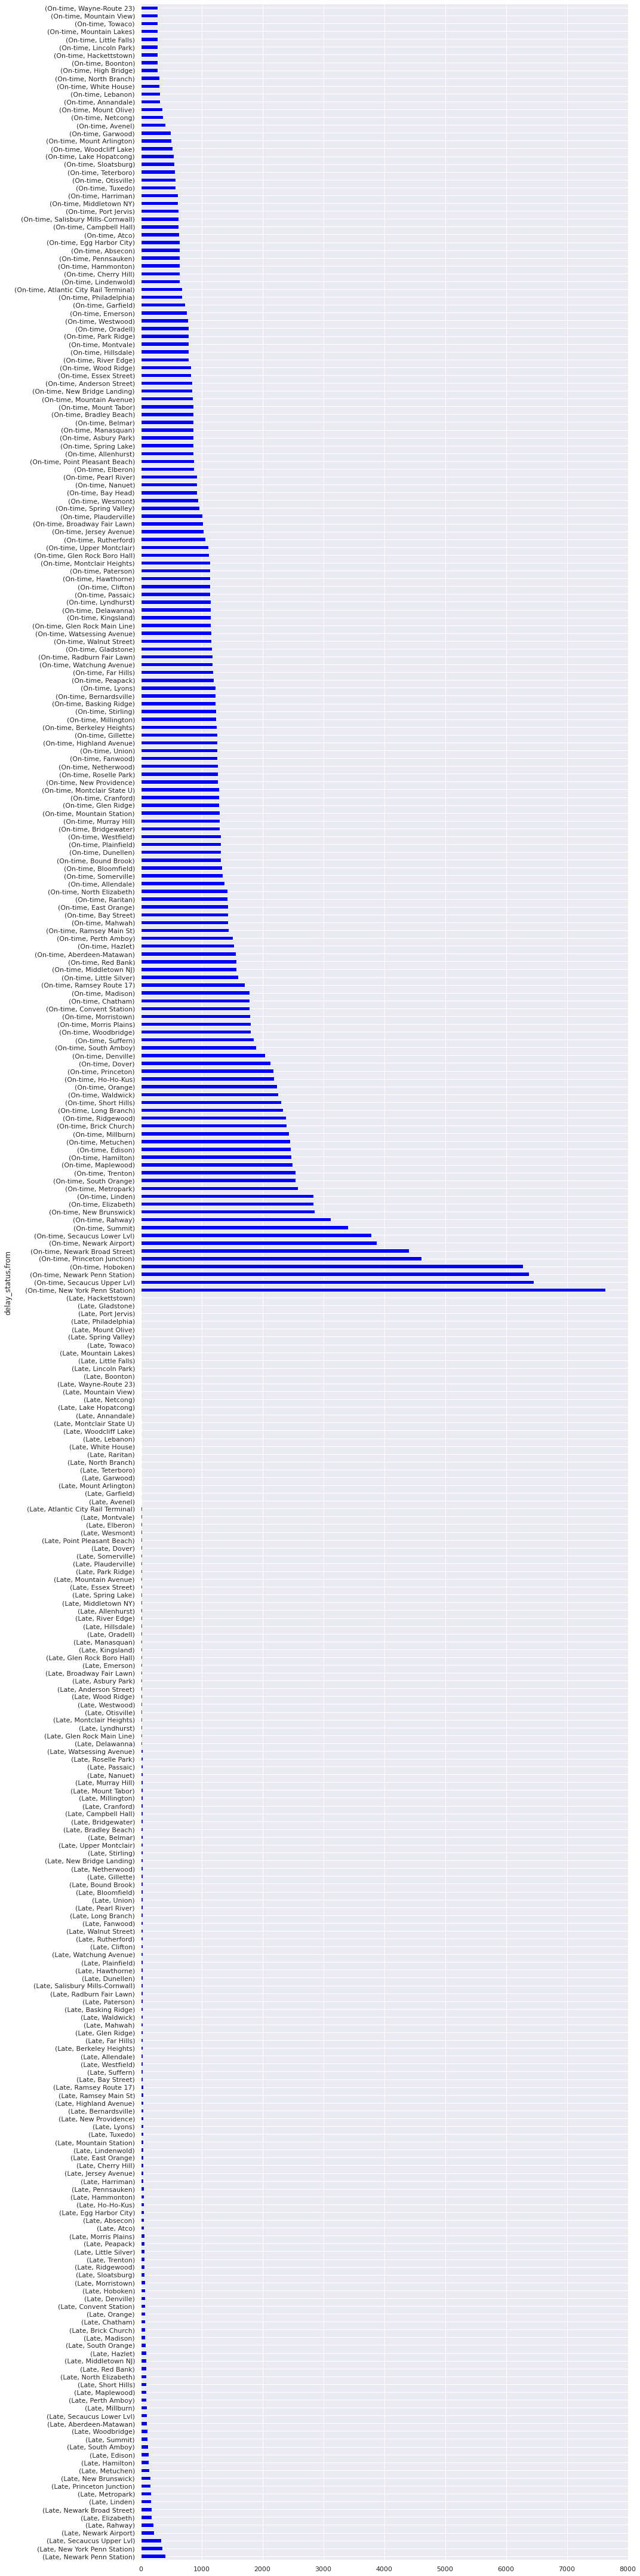

In [ ]:
plt.figure(figsize=(15, 60))
njt_1803_filtered.groupby('delay_status')['from'].value_counts().plot(kind='barh', color=['blue'])
plt.tight_layout()
plt.show()

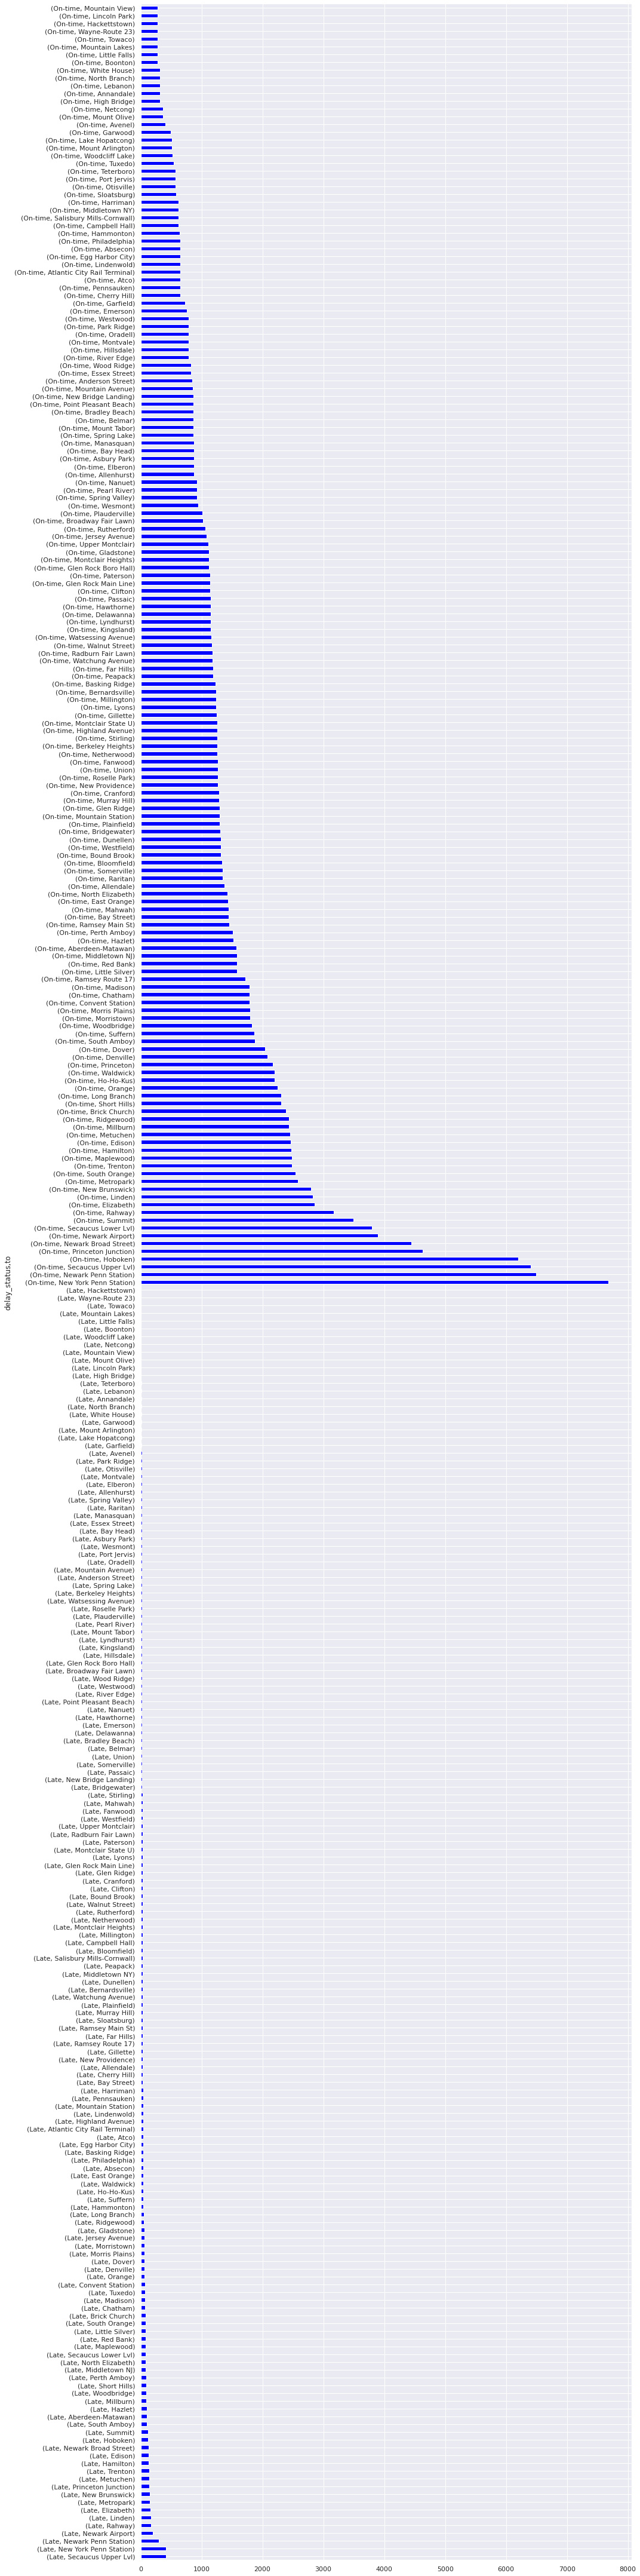

In [ ]:
plt.figure(figsize=(15, 60))
njt_1803_filtered.groupby('delay_status')['to'].value_counts().plot(kind='barh', color=['blue'])
plt.tight_layout()
plt.show()

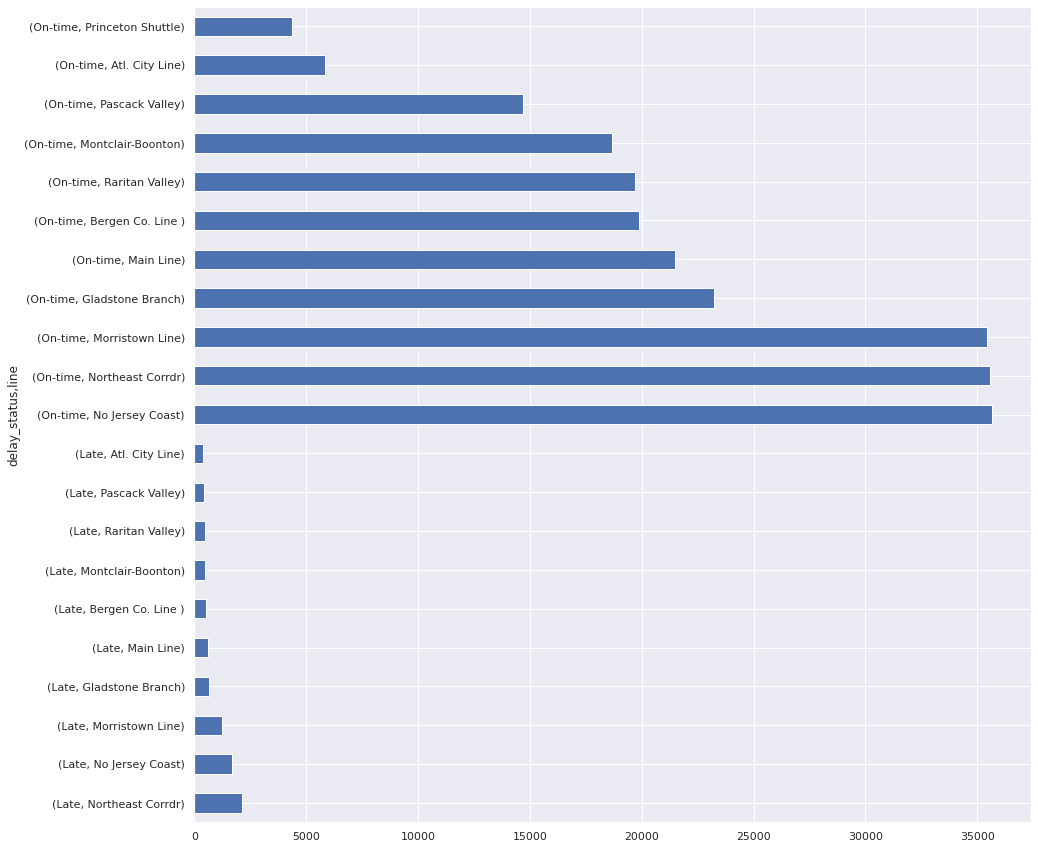

In [ ]:
plt.figure(figsize=(15, 15))
njt_1803_filtered.groupby('delay_status')['line'].value_counts().plot(kind='barh')
plt.show()

**The performance of each train line is clear. Train lines like Northeast Corrdr and Morristown Line have trains making trips on time versus lines with lower performance and late trips.**

# **3. Hold-out (splitting the data)**

---

**I will split the dataset into training data and testing data.**

In [ ]:
# I will drop all variables I won't be using
njt_1803_filtered.drop(['from_id','to_id','scheduled_time','actual_time','status','type','delay_minutes'], axis = 1, inplace = True)

In [ ]:
# y is the target variable
y = njt_1803_filtered['delay_status']
# X is the feature set
X = njt_1803_filtered.drop('delay_status', 1)
X = pd.get_dummies(X)
X = X.dropna(axis=1)

In [ ]:
X.head()

,stop_sequence,date_2018-03-01,date_2018-03-02,date_2018-03-03,date_2018-03-04,date_2018-03-05,date_2018-03-06,date_2018-03-07,date_2018-03-08,date_2018-03-09,date_2018-03-10,date_2018-03-11,date_2018-03-12,date_2018-03-13,date_2018-03-14,date_2018-03-15,date_2018-03-16,date_2018-03-17,date_2018-03-18,date_2018-03-19,date_2018-03-20,date_2018-03-21,date_2018-03-22,date_2018-03-23,date_2018-03-24,date_2018-03-25,date_2018-03-26,date_2018-03-27,date_2018-03-28,date_2018-03-29,date_2018-03-30,date_2018-03-31,train_id_0041,train_id_0042,train_id_0043,train_id_0044,train_id_0045,train_id_0046,train_id_0047,train_id_0048,...,to_Secaucus Upper Lvl,to_Short Hills,to_Sloatsburg,to_Somerville,to_South Amboy,to_South Orange,to_Spring Lake,to_Spring Valley,to_Stirling,to_Suffern,to_Summit,to_Teterboro,to_Towaco,to_Trenton,to_Tuxedo,to_Union,to_Upper Montclair,to_Waldwick,to_Walnut Street,to_Watchung Avenue,to_Watsessing Avenue,to_Wayne-Route 23,to_Wesmont,to_Westfield,to_Westwood,to_White House,to_Wood Ridge,to_Woodbridge,to_Woodcliff Lake,line_Atl. City Line,line_Bergen Co. Line,line_Gladstone Branch,line_Main Line,line_Montclair-Boonton,line_Morristown Line,line_No Jersey Coast,line_Northeast Corrdr,line_Pascack Valley,line_Princeton Shuttle,line_Raritan Valley
0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,3.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,5.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
# forcing get_dummies on the 'stop_sequence' variable
X = pd.get_dummies(X, columns=['stop_sequence'], prefix=['stop_sequence'], drop_first=True)

In [ ]:
# split into 80% training data and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

In [ ]:
# since this is an imbalanced class case, I will combine over & under-sample the dataset to even-up the classes 
# I will do that to the training set only as the testing set is real life data that should not be manipulated

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# setting up the over and under sampler
over = RandomOverSampler(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.85)
# first performing oversampling to minority class
X_over, y_over = over.fit_resample(X_train, y_train)
print(f"Oversampled: {Counter(y_over)}")

# combining under sampling 
X_train_comb_sample, y_train_comb_sample = under.fit_resample(X_over, y_over)
print(f"Combined Random Sampling: {Counter(y_train_comb_sample)}")


Oversampled: Counter({'On-time': 187620, 'Late': 56286})
Combined Random Sampling: Counter({'On-time': 66218, 'Late': 56286})


**Now with 66,218 On-time train samples and 56,286 Late train samples this seems to be an almost balanced training set to avoid bias later when training the classifier. The test set was not touched to preserve the real life data.**

# **4. Feature Engineering**

---

**I will use SelectKBest and PCA for feature extraction.**

## **4.1 SelectKBest**

In [ ]:
# Create the object for SelectKBest and fit and transform the data
selector = SelectKBest(score_func=chi2, k='all')
selector.fit_transform(X_test,y_test)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
X_test_Kbest = X_test.iloc[:,cols]

In [ ]:
X_test_Kbest.head()

,date_2018-03-01,date_2018-03-02,date_2018-03-03,date_2018-03-04,date_2018-03-05,date_2018-03-06,date_2018-03-07,date_2018-03-08,date_2018-03-09,date_2018-03-10,date_2018-03-11,date_2018-03-12,date_2018-03-13,date_2018-03-14,date_2018-03-15,date_2018-03-16,date_2018-03-17,date_2018-03-18,date_2018-03-19,date_2018-03-20,date_2018-03-21,date_2018-03-22,date_2018-03-23,date_2018-03-24,date_2018-03-25,date_2018-03-26,date_2018-03-27,date_2018-03-28,date_2018-03-29,date_2018-03-30,date_2018-03-31,train_id_0041,train_id_0042,train_id_0043,train_id_0044,train_id_0045,train_id_0046,train_id_0047,train_id_0048,train_id_0049,...,to_White House,to_Wood Ridge,to_Woodbridge,to_Woodcliff Lake,line_Atl. City Line,line_Bergen Co. Line,line_Gladstone Branch,line_Main Line,line_Montclair-Boonton,line_Morristown Line,line_No Jersey Coast,line_Northeast Corrdr,line_Pascack Valley,line_Princeton Shuttle,line_Raritan Valley,stop_sequence_2.0,stop_sequence_3.0,stop_sequence_4.0,stop_sequence_5.0,stop_sequence_6.0,stop_sequence_7.0,stop_sequence_8.0,stop_sequence_9.0,stop_sequence_10.0,stop_sequence_11.0,stop_sequence_12.0,stop_sequence_13.0,stop_sequence_14.0,stop_sequence_15.0,stop_sequence_16.0,stop_sequence_17.0,stop_sequence_18.0,stop_sequence_19.0,stop_sequence_20.0,stop_sequence_21.0,stop_sequence_22.0,stop_sequence_23.0,stop_sequence_24.0,stop_sequence_25.0,stop_sequence_26.0
63488,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
209305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
166401,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27904,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
152248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## **4.2 PCA**


In [ ]:
# We will use StandardScaler to help standardize the dataset’s features onto unit scale
from sklearn.preprocessing import StandardScaler

X_test_std = StandardScaler().fit_transform(X_test)

Text(0, 0.5, 'cumulative explained variance')

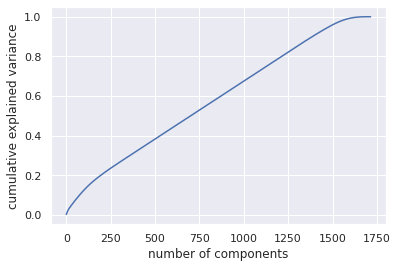

In [ ]:
# We will plot explained variance ratio and choose a number of components that "capture" at least 90% of the variance
from sklearn.decomposition import PCA

pca = PCA().fit(X_test_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
# We will get the PCA using 1350 components as per the plot above (90% of variance)
pca = PCA(n_components = 1350)
principalComponents = pca.fit_transform(X_test_std)
pcaDf_test_std = pd.DataFrame(data = principalComponents)

In [ ]:
pcaDf_test_std.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48606 entries, 0 to 48605
Columns: 1350 entries, 0 to 1349
dtypes: float64(1350)
memory usage: 500.6 MB


# **5. Models**

---

## **5.1. Supervised learning models using features from SelectKbest**

### **5.1.1. Decision Tree - Classifier (SelectKbest)**

**Using GridSearchCV to get the best parameters**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [ ]:
# Using GridSearchCV to get the best parameters (I'm using a range 40 - 50 because this is the 3rd run and I got good results within this range)
tree_para = {'criterion':['gini','entropy'], 'splitter':['best','random'], 'max_depth':np.arange(40, 50)}
dtree_model = DecisionTreeClassifier(random_state = 1)
dt_clf = GridSearchCV(dtree_model, tree_para, cv=3)
dt_clf.fit(X_test_Kbest, y_test)
tree_model = dt_clf.best_estimator_
print (dt_clf.best_score_, dt_clf.best_params_) 

0.9694276426778586 {'criterion': 'gini', 'max_depth': 48, 'splitter': 'best'}


**Training and timing the Decision Tree - Classifier model**

In [ ]:
# train the model (Decision Tree / SelectKbest) - (previous gini/43/random)

# Time the decision tree
start_time = time.monotonic()

# Initialize and fit the model
tr_dt_clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 48 , splitter = 'best', random_state = 1)
tr_dt_clf.fit(X_train_comb_sample, y_train_comb_sample)

end_time = time.monotonic()
print("\n The time it took to train the decission tree model: {}".format(timedelta(seconds=end_time - start_time)))


 The time it took to train the decission tree model: 0:00:37.360584


**Decision Tree - Classifier (SelectKbest) confusion matrix**

In [ ]:
# confusion matrix

# generate predictions on the test data
njt1803_dt_Kb_predicion = tr_dt_clf.predict(X_test)
confusion = confusion_matrix(y_test, njt1803_dt_Kb_predicion, labels=['Late', 'On-time'])
print(confusion)

[[ 1326   437]
 [ 2133 44710]]


**Decision Tree - Classifier (SelectKbest) classification report**

In [ ]:
# classification report

njt1803_dt_Kb_report = classification_report(y_test, njt1803_dt_Kb_predicion)
print(njt1803_dt_Kb_report)

              precision    recall  f1-score   support

        Late       0.38      0.75      0.51      1763
     On-time       0.99      0.95      0.97     46843

    accuracy                           0.95     48606
   macro avg       0.69      0.85      0.74     48606
weighted avg       0.97      0.95      0.96     48606



### **5.1.2. Random Forest (SelectKbest)**

**Using GridSearchCV to get the best parameters**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the parameter grid 
rf_param = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100, 150, 1000] 
}   
# Create a based model
rf_model = RandomForestClassifier(random_state = 2)
# Instantiate the grid search model
rf_clf = GridSearchCV(rf_model, rf_param, cv = 3, n_jobs = -1, verbose = 2)
rf_clf.fit(X_test_Kbest, y_test)
rfc_model = rf_clf.best_estimator_
print (rf_clf.best_score_, rf_clf.best_params_)         

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 51.8min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 82.1min finished


0.9637287577665309 {'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 50}


**Training and timing the random forest model**

In [ ]:
# train the model (Random Forest Classifier / SelectKbest)

# Time the Random Forest Classifier
start_time = time.monotonic()

# Initialize and fit the model
tr_rf_clf = RandomForestClassifier(bootstrap = 'True', max_depth = 80 , max_features = 2, 
                                   min_samples_leaf = 3, min_samples_split = 8, n_estimators = 50,
                                   random_state = 2)
tr_rf_clf.fit(X_train_comb_sample, y_train_comb_sample)

end_time = time.monotonic()
print("\n The time it took to train the random forest model: {}".format(timedelta(seconds=end_time - start_time)))


 The time it took to train the random forest model: 0:00:12.992763


**Random Forest (SelectKbest) confusion matrix**

In [ ]:
# confusion matrix

# generate predictions on the test data
njt1803_rf_Kb_predicion = tr_rf_clf.predict(X_test)
confusion = confusion_matrix(y_test, njt1803_rf_Kb_predicion, labels=['Late', 'On-time'])
print(confusion)

[[  313  1450]
 [ 1450 45393]]


**Random Forest (SelectKbest) classification report**

In [ ]:
# classification report

njt1803_rf_Kb_report = classification_report(y_test, njt1803_rf_Kb_predicion)
print(njt1803_rf_Kb_report)

              precision    recall  f1-score   support

        Late       0.18      0.18      0.18      1763
     On-time       0.97      0.97      0.97     46843

    accuracy                           0.94     48606
   macro avg       0.57      0.57      0.57     48606
weighted avg       0.94      0.94      0.94     48606



### **5.1.3. KNN (SelectKbest)**


**Training and timing the KNN model**

In [ ]:
# train the model (KNN / SelectKbest)
from sklearn.neighbors import KNeighborsClassifier

# Time the Random Forest Classifier
start_time = time.monotonic()

# Initialize and fit the model
tr_knn_clf = KNeighborsClassifier(n_neighbors = 2, weights = 'uniform')
tr_knn_clf.fit(X_train_comb_sample, y_train_comb_sample)

end_time = time.monotonic()
print("\n The time it took to train the KNN model: {}".format(timedelta(seconds=end_time - start_time)))


 The time it took to train the KNN model: 0:01:40.327615


**KNN (SelectKbest) confusion matrix**

In [ ]:
# confusion matrix

# generate predictions on the test data
njt1803_knn_Kb_predicion = tr_knn_clf.predict(X_test)
confusion = confusion_matrix(y_test, njt1803_knn_Kb_predicion, labels=['Late', 'On-time'])
print(confusion)

[[ 1180   583]
 [18932 27911]]


**KNN (SelectKbest) classification report**

In [ ]:
# classification report

njt1803_knn_Kb_report = classification_report(y_test, njt1803_knn_Kb_predicion)
print(njt1803_knn_Kb_report)

              precision    recall  f1-score   support

        Late       0.06      0.67      0.11      1763
     On-time       0.98      0.60      0.74     46843

    accuracy                           0.60     48606
   macro avg       0.52      0.63      0.42     48606
weighted avg       0.95      0.60      0.72     48606



### **5.1.4. Linear SVC (SelectKbest)**

**Training and timing the Linear SVC model**

In [ ]:
# train the model (SVC / SelectKbest)
from sklearn.svm import LinearSVC

# Time the Random Forest Classifier
start_time = time.monotonic()

# Initialize and fit the model
tr_svc = LinearSVC(C = 0.01, loss = 'squared_hinge')
tr_svc.fit(X_train_comb_sample, y_train_comb_sample)

end_time = time.monotonic()
print("\n The time it took to train the linearSVC model: {}".format(timedelta(seconds=end_time - start_time)))


 The time it took to train the linearSVC model: 0:00:04.450241


**Linear SVC (SelectKbest) confusion matrix**

In [ ]:
# confusion matrix

# generate predictions on the test data
njt1803_svc_Kb_predicion = tr_svc.predict(X_test)
confusion = confusion_matrix(y_test, njt1803_svc_Kb_predicion, labels=['Late', 'On-time'])
print(confusion)

[[ 1352   411]
 [ 9060 37783]]


**Linear SVC (SelectKbest) classification report**

In [ ]:
# classification report

njt1803_svc_Kb_report = classification_report(y_test, njt1803_svc_Kb_predicion)
print(njt1803_svc_Kb_report)

              precision    recall  f1-score   support

        Late       0.13      0.77      0.22      1763
     On-time       0.99      0.81      0.89     46843

    accuracy                           0.81     48606
   macro avg       0.56      0.79      0.56     48606
weighted avg       0.96      0.81      0.86     48606



### **5.1.5. Logistic regression (SelectKbest)**

**Using GridSearchCV to get the best parameters**

In [ ]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C' : np.logspace(-4, 4, 20), 
              'penalty' : ['l1', 'l2']}
              
logreg = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
logreg.fit(X_test_Kbest, y_test)
logreg_model = logreg.best_estimator_
print (logreg.best_score_, logreg.best_params_)     


0.9637287585516173 {'C': 0.0001, 'penalty': 'l2'}


**Training and timing the logistic regression model**

In [ ]:
# train the model (logistic / SelectKbest)

# Time the Random Forest Classifier
start_time = time.monotonic()

# Initialize and fit the model
tr_logreg_clf = LogisticRegression(C= 0.0001, penalty= 'l2')
tr_logreg_clf.fit(X_train_comb_sample, y_train_comb_sample)

end_time = time.monotonic()
print("\n The time it took to train the logistic regression model: {}".format(timedelta(seconds=end_time - start_time)))


 The time it took to train the logistic regression model: 0:00:02.129230


**Logisic regression (SelectKbest) confusion matrix**

In [ ]:
# confusion matrix

# generate predictions on the test data
njt1803_logreg_Kb_predicion = tr_logreg_clf.predict(X_test)
confusion = confusion_matrix(y_test, njt1803_logreg_Kb_predicion, labels=['Late', 'On-time'])
print(confusion)

[[  541  1222]
 [ 2934 43909]]


**Logisic regression (SelectKbest) classification report**

In [ ]:
# classification report

njt1803_logreg_Kb_report = classification_report(y_test, njt1803_logreg_Kb_predicion)
print(njt1803_logreg_Kb_report)

              precision    recall  f1-score   support

        Late       0.16      0.31      0.21      1763
     On-time       0.97      0.94      0.95     46843

    accuracy                           0.91     48606
   macro avg       0.56      0.62      0.58     48606
weighted avg       0.94      0.91      0.93     48606



### **5.1.6. Gradient boosting classifier (SelectKbest)**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

## Using GridSearchCV to get the best parameters

#param_grid = {
#    'loss':['deviance'],
#    'learning_rate': [0.01, 0.075, 0.1, 0.2],
#    'min_samples_split': [1000],
#    'min_samples_leaf': [100],
#    'max_depth':[3,5,8],
#    'max_features':['log2'],
#    'criterion': ['friedman_mse', 'mae'],
#    'subsample':[0.5, 0.8, 0.9, 1.0],
#    'n_estimators':[10, 20, 100]
#    }
## passing the scoring function in the GridSearchCV
#gradientboost = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=3, n_jobs=-1)

#gradientboost.fit(X_test_Kbest, y_test)

**Training and timing the Gradient boosting classifier model**

In [ ]:
# Train the Gradient boosting classifier model using features from SelectKbest
# hyper-parameters are from a previous run of gridSearchCV - trying to lower running time to less than 24 hours

# time the Gradient boosting classifier
start_time = time.monotonic()

# Initialize and fit the model
tr_gradientboost_clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, min_samples_split=2,
                                                  min_samples_leaf=1, max_depth=3, max_features='sqrt',
                                                  criterion='friedman_mse', subsample=0.8, n_estimators=100)
tr_gradientboost_clf.fit(X_train_comb_sample, y_train_comb_sample)

end_time = time.monotonic()
print("\n The time it took to train the Gradient boosting classifier model: {}".format(timedelta(seconds=end_time - start_time)))


 The time it took to train the Gradient boosting classifier model: 0:00:27.197009


**Gradient boosting classifier (SelectKbest) confusion matrix**

In [ ]:
# confusion matrix

# generate predictions on the test data
njt1803_gradientboost_clf_Kb_predicion = tr_gradientboost_clf.predict(X_test)
confusion = confusion_matrix(y_test, njt1803_gradientboost_clf_Kb_predicion, labels=['Late', 'On-time'])
print(confusion)

[[  991   772]
 [ 7693 39150]]


**Gradient boosting classifier (SelectKbest) classification report**

In [ ]:
# classification report

njt1803_gradientboost_clf_report = classification_report(y_test, njt1803_gradientboost_clf_Kb_predicion)
print(njt1803_gradientboost_clf_report)

              precision    recall  f1-score   support

        Late       0.11      0.56      0.19      1763
     On-time       0.98      0.84      0.90     46843

    accuracy                           0.83     48606
   macro avg       0.55      0.70      0.55     48606
weighted avg       0.95      0.83      0.88     48606



## **5.2. Supervised learning models using features from PCA**

### **5.2.1. Decision Tree - Classifier (PCA)**

**Training and timing the Decision Tree - Classifier model**

In [ ]:
# train the model (Decision Tree / SelectKbest)
# hyper-parameters are from a previous run of gridSearchCV - trying to lower running time to less than 24 hours

# Time the decision tree
start_time = time.monotonic()

# Initialize and fit the model
tr_dt_clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 50 , splitter = 'random', random_state = 1)
tr_dt_clf.fit(X_train_comb_sample, y_train_comb_sample)

end_time = time.monotonic()
print("\n The time it took to train the decission tree model: {}".format(timedelta(seconds=end_time - start_time)))


 The time it took to train the decission tree model: 0:00:51.784606


**Decision Tree - Classifier (PCA) confusion matrix**

In [ ]:
# confusion matrix

# generate predictions on the test data
njt1803_dt_pca_predicion = tr_dt_clf.predict(X_test)
confusion = confusion_matrix(y_test, njt1803_dt_pca_predicion, labels=['Late', 'On-time'])
print(confusion)

[[ 1328   435]
 [ 2118 44725]]


**Decision Tree - Classifier (PCA) classification report**

In [ ]:
# classification report

njt1803_dt_pca_report = classification_report(y_test, njt1803_dt_pca_predicion)
print(njt1803_dt_pca_report)

              precision    recall  f1-score   support

        Late       0.39      0.75      0.51      1763
     On-time       0.99      0.95      0.97     46843

    accuracy                           0.95     48606
   macro avg       0.69      0.85      0.74     48606
weighted avg       0.97      0.95      0.96     48606



### **5.2.2. Random Forest (PCA)**

**Using GridSearchCV to get the best parameters**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the parameter grid
rf_param = {
    'bootstrap': [True],
    'max_depth': [40, 60, 80],
    'max_features': [2, 4, 8],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [10, 12, 20],
    'n_estimators': [50, 100, 200] 
}   
# Create a based model
rf_model = RandomForestClassifier(random_state = 2)
# Instantiate the grid search model
rf_clf = GridSearchCV(rf_model, rf_param, cv = 3, n_jobs = -1, verbose = 2)
rf_clf.fit(pcaDf_test_std, y_test)
rfc_model = rf_clf.best_estimator_
print (rf_clf.best_score_, rf_clf.best_params_)         

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 63.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 122.7min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 156.2min finished


0.9637493313582685 {'bootstrap': True, 'max_depth': 40, 'max_features': 8, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 50}


**Training and timing the random forest model**

In [ ]:
# train the model (Random Forest Classifier / SelectKbest)

# Time the Random Forest Classifier 
start_time = time.monotonic()

# Initialize and fit the model
tr_rf_clf = RandomForestClassifier(bootstrap = 'True', max_depth = 40 , max_features = 8, 
                                   min_samples_leaf = 4, min_samples_split = 10, n_estimators = 50,
                                   random_state = 2)
tr_rf_clf.fit(X_train_comb_sample, y_train_comb_sample)

end_time = time.monotonic()
print("\n The time it took to train the random forest model: {}".format(timedelta(seconds=end_time - start_time)))


 The time it took to train the random forest model: 0:00:27.675406


**Random Forest (PCA) confusion matrix**

In [ ]:
# confusion matrix

# generate predictions on the test data
njt1803_rf_pca_predicion = tr_rf_clf.predict(X_test)
confusion = confusion_matrix(y_test, njt1803_rf_pca_predicion, labels=['Late', 'On-time'])
print(confusion)

[[  605  1158]
 [ 2952 43891]]


**Random Forest (PCA) classification report**

In [ ]:
# classification report

njt1803_rf_pca_report = classification_report(y_test, njt1803_rf_pca_predicion)
print(njt1803_rf_pca_report)

              precision    recall  f1-score   support

        Late       0.17      0.34      0.23      1763
     On-time       0.97      0.94      0.96     46843

    accuracy                           0.92     48606
   macro avg       0.57      0.64      0.59     48606
weighted avg       0.95      0.92      0.93     48606



### **5.2.3. KNN (PCA)**


**Training and timing the KNN model**

In [ ]:
# train the model (KNN / SelectKbest)

# Time the Random Forest Classifier
start_time = time.monotonic()

# Initialize and fit the model
tr_knn_clf = KNeighborsClassifier(n_neighbors = 7, weights = 'uniform')
tr_knn_clf.fit(X_train_comb_sample, y_train_comb_sample)

end_time = time.monotonic()
print("\n The time it took to train the KNN model: {}".format(timedelta(seconds=end_time - start_time)))


 The time it took to train the KNN model: 0:02:42.916122


**KNN (PCA) confusion matrix**

In [ ]:
# confusion matrix

# generate predictions on the test data

start_time = time.monotonic()
njt1803_knn_pca_predicion = tr_knn_clf.predict(X_test)
confusion = confusion_matrix(y_test, njt1803_knn_pca_predicion, labels=['Late', 'On-time'])
print(confusion)
end_time = time.monotonic()
print("\n The time it took to run the confusion matrix: {}".format(timedelta(seconds=end_time - start_time)))

[[ 1260   503]
 [20279 26564]]

 The time it took to run the confusion matrix: 4:16:27.779951


**KNN (PCA) classification report**

In [ ]:
# classification report

njt1803_knn_pca_report = classification_report(y_test, njt1803_knn_pca_predicion)
print(njt1803_knn_pca_report)

              precision    recall  f1-score   support

        Late       0.06      0.71      0.11      1763
     On-time       0.98      0.57      0.72     46843

    accuracy                           0.57     48606
   macro avg       0.52      0.64      0.41     48606
weighted avg       0.95      0.57      0.70     48606



### **5.2.4. Linear SVC (PCA)**

**Training and timing the Linear SVC model**

In [ ]:
# train the model (SVC / SelectKbest)

# Time the Random Forest Classifier
start_time = time.monotonic()

# Initialize and fit the model
tr_svc = LinearSVC(C = 0.01, loss = 'squared_hinge')
tr_svc.fit(X_train_comb_sample, y_train_comb_sample)

end_time = time.monotonic()
print("\n The time it took to train the linearSVC model: {}".format(timedelta(seconds=end_time - start_time)))


 The time it took to train the linearSVC model: 0:00:05.173170


**Linear SVC (PCA) confusion matrix**

In [ ]:
# confusion matrix

# generate predictions on the test data
njt1803_svc_pca_predicion = tr_svc.predict(X_test)
confusion = confusion_matrix(y_test, njt1803_svc_pca_predicion, labels=['Late', 'On-time'])
print(confusion)

[[ 1352   411]
 [ 9060 37783]]


**Linear SVC (PCA) classification report**

In [ ]:
# classification report

njt1803_svc_pca_report = classification_report(y_test, njt1803_svc_pca_predicion)
print(njt1803_svc_pca_report)

              precision    recall  f1-score   support

        Late       0.13      0.77      0.22      1763
     On-time       0.99      0.81      0.89     46843

    accuracy                           0.81     48606
   macro avg       0.56      0.79      0.56     48606
weighted avg       0.96      0.81      0.86     48606



### **5.2.5. Logistic regression (PCA)**

**Training and timing the logistic regression model**

In [ ]:
# train the model (logistic / SelectKbest)

from sklearn.linear_model import LogisticRegression

# Time the Random Forest Classifier
start_time = time.monotonic()

# In a previous run of GridSearchCV I obtained  C= 4.281332398719396, penalty= 'l2']
tr_logreg_clf = LogisticRegression(C= 4.281332398719396, penalty= 'l2')
tr_logreg_clf.fit(X_train_comb_sample, y_train_comb_sample)

end_time = time.monotonic()
print("\n The time it took to train the logistic regression model: {}".format(timedelta(seconds=end_time - start_time)))


 The time it took to train the logistic regression model: 0:00:18.936000


**Logisic regression (PCA) confusion matrix**

In [ ]:
# confusion matrix

# generate predictions on the test data
njt1803_logreg_pca_predicion = tr_logreg_clf.predict(X_test)
confusion = confusion_matrix(y_test, njt1803_logreg_pca_predicion, labels=['Late', 'On-time'])
print(confusion)

[[ 1429   334]
 [ 9292 37551]]


**Logisic regression (PCA) classification report**

In [ ]:
# classification report

njt1803_logreg_pca_report = classification_report(y_test, njt1803_logreg_pca_predicion)
print(njt1803_logreg_pca_report)

              precision    recall  f1-score   support

        Late       0.13      0.81      0.23      1763
     On-time       0.99      0.80      0.89     46843

    accuracy                           0.80     48606
   macro avg       0.56      0.81      0.56     48606
weighted avg       0.96      0.80      0.86     48606



### **5.1.6. Gradient boosting classifier (PCA)**

**Using GridSearchCV to get the best parameters**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Using GridSearchCV to get the best parameters (I decreased the ranges because I ran this a few times already. Trying to decrease running time)

param_grid = {
    'loss':['deviance'],
    'learning_rate': [0.1, 0.2],
    'min_samples_split': np.linspace(0.1, 0.5, 4),
    'min_samples_leaf': np.linspace(0.1, 0.5, 4),
    'max_depth':[3,5],
    'max_features':['sqrt'],
    'subsample':[0.5, 0.8,1.0],
    'n_estimators':[20, 100]
    }
# passing the scoring function in the GridSearchCV
gradientboost = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=3, n_jobs=-1, verbose=2)

gradientboost.fit(pcaDf_test_std, y_test)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 36.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 57.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed: 61.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
             para

**Training and timing the Gradient boosting classifier model**

In [ ]:
# Train the model (Gradient boosting classifier / SelectKbest)

# time the Gradient boosting classifier
start_time = time.monotonic()

params = {'learning_rate': 0.1,
          'min_samples_leaf': 1,
          'min_samples_split': 2,
          'n_estimators': 100,
          'max_depth': 3,
          'criterion': 'friedman_mse',
          'loss': 'deviance'}

# Initialize and fit the model
tr_gradientboost_clf = ensemble.GradientBoostingClassifier(**params)
tr_gradientboost_clf.fit(X_train_comb_sample, y_train_comb_sample)

end_time = time.monotonic()
print("\n The time it took to train the Gradient boosting classifier model: {}".format(timedelta(seconds=end_time - start_time)))


 The time it took to train the Gradient boosting classifier model: 0:22:58.948013


**Gradient boosting classifier (PCA) confusion matrix**

In [ ]:
# confusion matrix

# generate predictions on the test data
njt1803_gradientboost_clf_pca_predicion = tr_gradientboost_clf.predict(X_test)
confusion = confusion_matrix(y_test, njt1803_gradientboost_clf_pca_predicion, labels=['Late', 'On-time'])
print(confusion)

[[ 1025   738]
 [ 7431 39412]]


**Gradient boosting classifier (PCA) classification report**

In [ ]:
# classification report

njt1803_gradientboost_clf_pca_report = classification_report(y_test, njt1803_gradientboost_clf_pca_predicion)
print(njt1803_gradientboost_clf_pca_report)

              precision    recall  f1-score   support

        Late       0.12      0.58      0.20      1763
     On-time       0.98      0.84      0.91     46843

    accuracy                           0.83     48606
   macro avg       0.55      0.71      0.55     48606
weighted avg       0.95      0.83      0.88     48606



## **5.3. Unsupervised learning models**

### **5.3.1. K-means using PCA**

In [ ]:
njt_1803_filtered.head(30)

,date,train_id,stop_sequence,from,to,line,delay_status
0,2018-03-01,3805,1.0,New York Penn Station,New York Penn Station,Northeast Corrdr,On-time
1,2018-03-01,3805,2.0,New York Penn Station,Secaucus Upper Lvl,Northeast Corrdr,On-time
2,2018-03-01,3805,3.0,Secaucus Upper Lvl,Newark Penn Station,Northeast Corrdr,On-time
3,2018-03-01,3805,4.0,Newark Penn Station,Newark Airport,Northeast Corrdr,On-time
4,2018-03-01,3805,5.0,Newark Airport,North Elizabeth,Northeast Corrdr,On-time
5,2018-03-01,3805,6.0,North Elizabeth,Elizabeth,Northeast Corrdr,On-time
6,2018-03-01,3805,7.0,Elizabeth,Linden,Northeast Corrdr,On-time
7,2018-03-01,3805,8.0,Linden,Rahway,Northeast Corrdr,On-time
8,2018-03-01,3805,9.0,Rahway,Metropark,Northeast Corrdr,On-time
9,2018-03-01,3805,10.0,Metropark,Metuchen,Northeast Corrdr,On-time


In [ ]:
njt_1803_filtered.drop(['line','date'], axis = 1, inplace = True) # reducing dimensions to reduce running time. I'll be using get dummies in the next step.

In [ ]:
njt_1803_dumm = pd.get_dummies(njt_1803_filtered, columns=['from', 'to', 'delay_status'], prefix=['from', 'to', 'delay_status'], drop_first=True)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# scaling the dataset
scaler = StandardScaler()
njt_1803_dumm_std = pd.DataFrame(scaler.fit_transform(njt_1803_dumm), columns=njt_1803_dumm.columns, index=njt_1803_dumm.index)

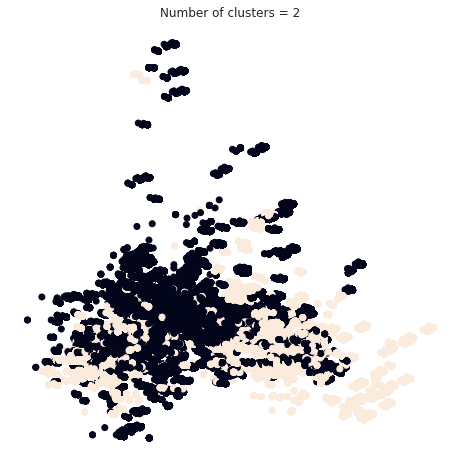

Silhouette score for 2 cluster k-means: 0.012392186587196078


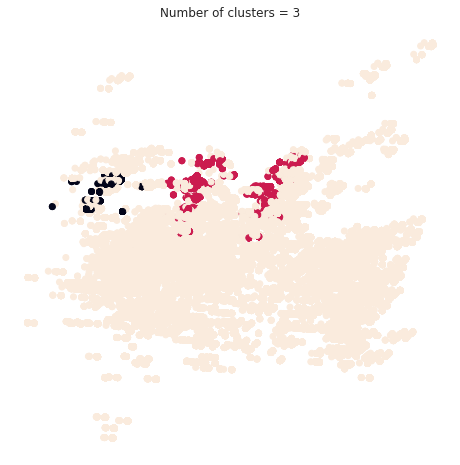

Silhouette score for 3 cluster k-means: -0.0804597635873781


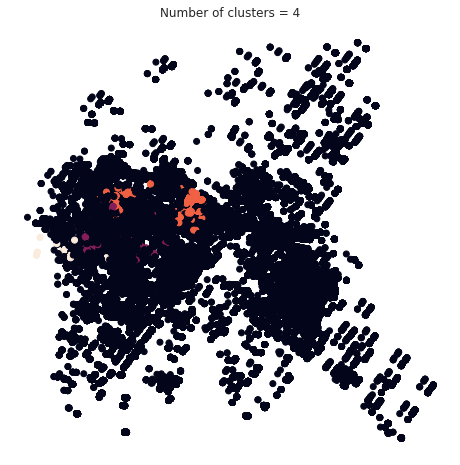

Silhouette score for 4 cluster k-means: -0.10159769982179853


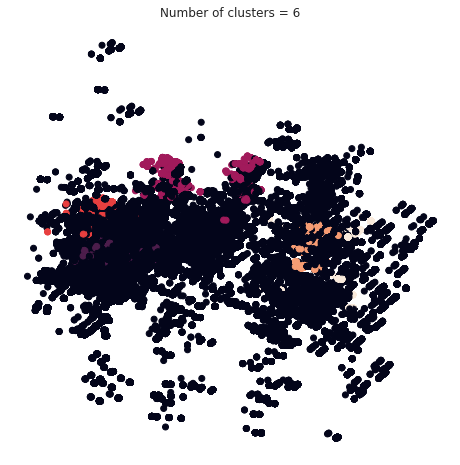

Silhouette score for 6 cluster k-means: -0.09423388489827049


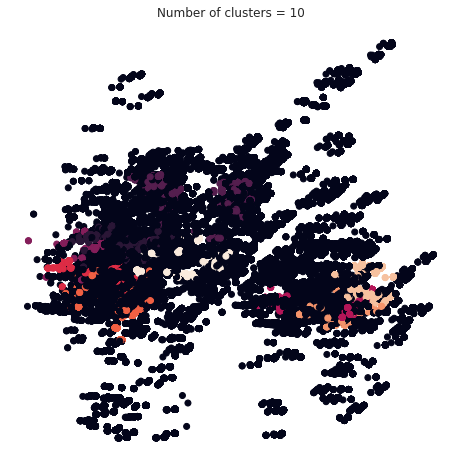

Silhouette score for 10 cluster k-means: -0.08242537353739737

 The time it took to run K-means: 2:13:51.074046


In [ ]:
# running K-means with a range of n_clusters from 2 - 10
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

start_time = time.monotonic()
cluster_numbers = [2,3,4,6,10]
for i in cluster_numbers:
    k_means = KMeans(n_clusters=i, random_state=3)
    k_means.fit(njt_1803_dumm_std)
    K_cluster = k_means.predict(njt_1803_dumm_std)

    pca = PCA(n_components=2).fit_transform(njt_1803_dumm_std)

    plt.figure(figsize=(8,8))
    plt.scatter(pca[:,0], pca[:,1], c=K_cluster)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title('Number of clusters = ' + str(i))
    plt.show()

    print('Silhouette score for {} cluster k-means: {}'.format((i),
          metrics.silhouette_score(njt_1803_dumm_std, K_cluster, metric='euclidean')))

end_time = time.monotonic()
print("\n The time it took to run K-means: {}".format(timedelta(seconds=end_time - start_time)))

### **5.3.2. DBSCAN using t-SNE**

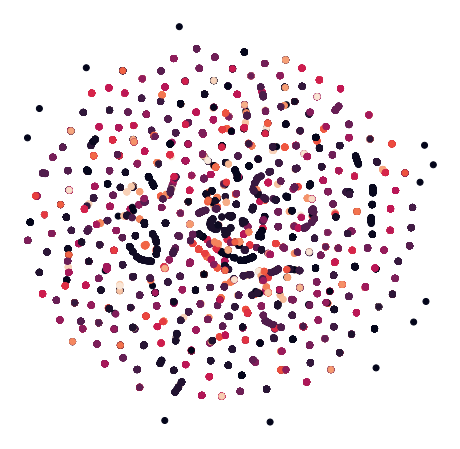

Silhouette score for DBSCAN with 2 min_samples=0.8792579239499304


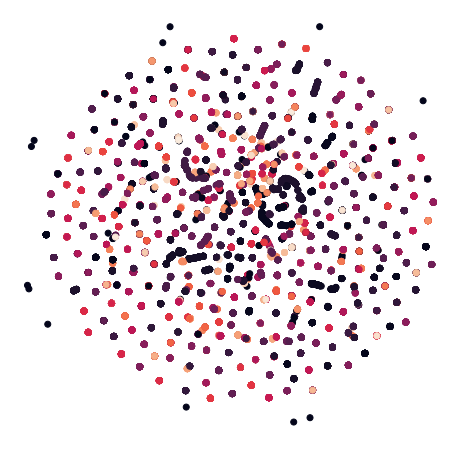

Silhouette score for DBSCAN with 3 min_samples=0.8667458874062085


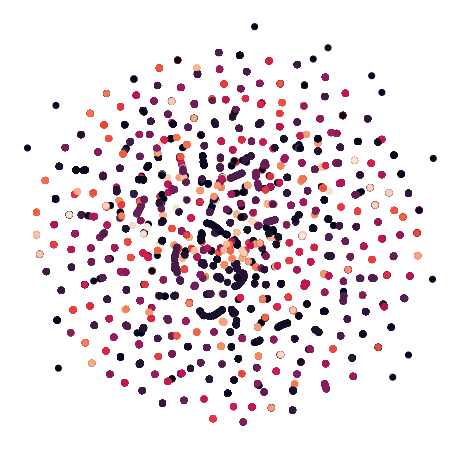

Silhouette score for DBSCAN with 4 min_samples=0.8529292268135712


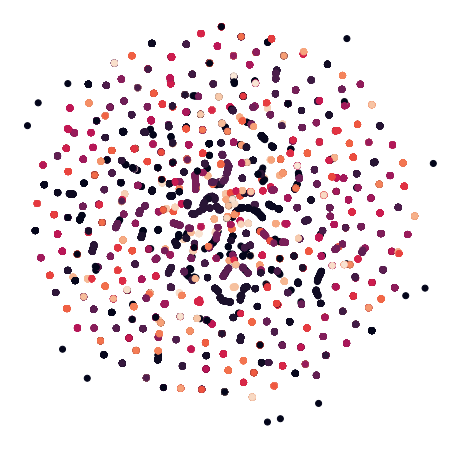

Silhouette score for DBSCAN with 6 min_samples=0.829392538775213


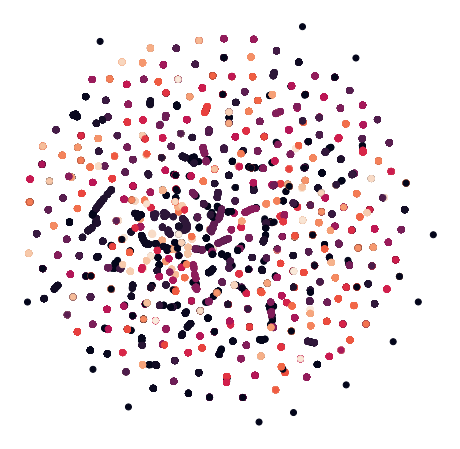

Silhouette score for DBSCAN with 10 min_samples=0.7903712986315251

 The time it took to run the DBSCAN: 0:52:20.044903


In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

# I will select random rows about 10% of the dataset (24,302 observations) just to decrease the running time
njt_1803_dumm_std_mini_10 = njt_1803_dumm_std.sample(frac =.1, replace = False, random_state = 1) 

start_time = time.monotonic()
sample_range = [2,3,4,6,10]
for i in sample_range:
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=1, min_samples=i)

    # Fit model
    clusters = dbscan_cluster.fit_predict(njt_1803_dumm_std_mini_10)

    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    tsne_results = tsne.fit_transform(njt_1803_dumm_std_mini_10)

    plt.figure(figsize=(8,8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

    print('Silhouette score for DBSCAN with {} min_samples={}'.format((i),
    metrics.silhouette_score(njt_1803_dumm_std_mini_10, clusters, metric='euclidean')))

end_time = time.monotonic()
print("\n The time it took to run the DBSCAN: {}".format(timedelta(seconds=end_time - start_time)))

**According to the Silhouette score obtained from both K-means using PCA and for DBSCAN using t-SNE, the better performing clustering algorithm here is the DBSCAN with 2 min_samples (Silhouette score = 0.8792) this is the best result out of the chosen range.**

## **5.4. Neural network (3 layer ANN)**

In [ ]:
# converting categorical variables to continuous
y_train_comb_sample_dummies = pd.get_dummies(y_train_comb_sample)
y_train_comb_sample_dummies = y_train_comb_sample_dummies.dropna(axis=1)
y_test_dummies = pd.get_dummies(y_test)
y_test_dummies = y_test_dummies.dropna(axis=1)

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48606 entries, 63488 to 23097
Columns: 1716 entries, date_2018-03-01 to stop_sequence_26.0
dtypes: uint8(1716)
memory usage: 79.9 MB


In [ ]:
X_test.head()

,date_2018-03-01,date_2018-03-02,date_2018-03-03,date_2018-03-04,date_2018-03-05,date_2018-03-06,date_2018-03-07,date_2018-03-08,date_2018-03-09,date_2018-03-10,date_2018-03-11,date_2018-03-12,date_2018-03-13,date_2018-03-14,date_2018-03-15,date_2018-03-16,date_2018-03-17,date_2018-03-18,date_2018-03-19,date_2018-03-20,date_2018-03-21,date_2018-03-22,date_2018-03-23,date_2018-03-24,date_2018-03-25,date_2018-03-26,date_2018-03-27,date_2018-03-28,date_2018-03-29,date_2018-03-30,date_2018-03-31,train_id_0041,train_id_0042,train_id_0043,train_id_0044,train_id_0045,train_id_0046,train_id_0047,train_id_0048,train_id_0049,...,to_White House,to_Wood Ridge,to_Woodbridge,to_Woodcliff Lake,line_Atl. City Line,line_Bergen Co. Line,line_Gladstone Branch,line_Main Line,line_Montclair-Boonton,line_Morristown Line,line_No Jersey Coast,line_Northeast Corrdr,line_Pascack Valley,line_Princeton Shuttle,line_Raritan Valley,stop_sequence_2.0,stop_sequence_3.0,stop_sequence_4.0,stop_sequence_5.0,stop_sequence_6.0,stop_sequence_7.0,stop_sequence_8.0,stop_sequence_9.0,stop_sequence_10.0,stop_sequence_11.0,stop_sequence_12.0,stop_sequence_13.0,stop_sequence_14.0,stop_sequence_15.0,stop_sequence_16.0,stop_sequence_17.0,stop_sequence_18.0,stop_sequence_19.0,stop_sequence_20.0,stop_sequence_21.0,stop_sequence_22.0,stop_sequence_23.0,stop_sequence_24.0,stop_sequence_25.0,stop_sequence_26.0
63488,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
209305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
166401,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27904,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
152248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_test_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48606 entries, 63488 to 23097
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Late     48606 non-null  uint8
 1   On-time  48606 non-null  uint8
dtypes: uint8(2)
memory usage: 474.7 KB


In [ ]:
y_test_dummies.head()

,Late,On-time
63488,0,1
209305,0,1
166401,0,1
27904,0,1
152248,0,1


In [ ]:
X_test_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48606 entries, 63488 to 23097
Columns: 1716 entries, date_2018-03-01 to stop_sequence_26.0
dtypes: uint8(1716)
memory usage: 79.9 MB


In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# finding the input shape
X_train_comb_sample[0].shape

(1716,)

In [ ]:
start_time = time.monotonic()

# Defining the model
model = Sequential()
# our first dense layer
model.add(Dense(128, input_shape=(1716,), activation='relu'))
# our second dense layer
model.add(Dense(64, activation='relu'))
# last layer is the output layer
model.add(Dense(2, activation='softmax'))

# displaying the ANN structure
model.summary()
# Compiling the model
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

# training the model
model.fit(X_train_comb_sample, y_train_comb_sample_dummies, batch_size=16, epochs=10, verbose=1)

end_time = time.monotonic()
print("\n The time it took to train the Artificial Neural network: {}".format(timedelta(seconds=end_time - start_time)))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               219776    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 130       
Total params: 228,162
Trainable params: 228,162
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7657/7657 [==============================] - 16s 2ms/step - loss: 0.6217 - accuracy: 0.6464
Epoch 2/10
7657/7657 [==============================] - 15s 2ms/step - loss: 0.4239 - accuracy: 0.8107
Epoch 3/10
7657/7657 [==============================] - 15s 2ms/step - loss: 0.2990 - accuracy: 0.8833
Epoch 4/10
7657/7657 [==============================] - 15s 2ms/step 

**Neural network confusion matrix**

In [ ]:
# confusion matrix

# generate predictions on the test data
njt1803_neural_predicion = model.predict(X_test)

confusion = confusion_matrix(y_test_dummies.values.argmax(axis=1), njt1803_neural_predicion.argmax(axis=1))
print(confusion)

[[ 1373   390]
 [  753 46090]]


**Neural network classification report**

In [ ]:
# classification report

njt1803_neural_report = classification_report(y_test_dummies.values.argmax(axis=1), njt1803_neural_predicion.argmax(axis=1))
print(njt1803_neural_report)

              precision    recall  f1-score   support

           0       0.65      0.78      0.71      1763
           1       0.99      0.98      0.99     46843

    accuracy                           0.98     48606
   macro avg       0.82      0.88      0.85     48606
weighted avg       0.98      0.98      0.98     48606



# **6. Conclusion**

---

## **6.1. Classification report summary**

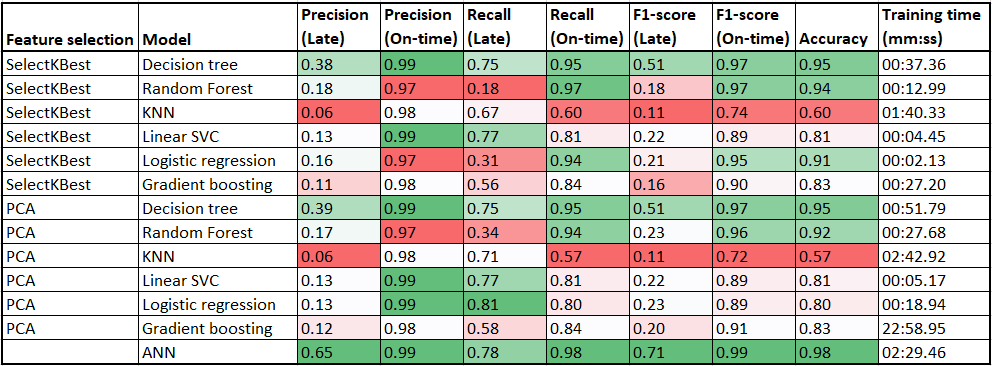

## **6.2. In summary**

Results show that the models show an accuracy of 0.80 up to 0.98 except the KNN model which is below 0.60 which all other models are approximately 80% - 98% accurate which may seem good at first. 

If a train is actually late (Actual Positive) yet the system incorrectly predicted it as on-time (False Negative), the issue with the line or train might go undetected and unimproved. This will cause frustration among passengers and eventually they will look for other alternatives and there will be an impact since that means contributing to annual operating losses. As such, we will accept the lower cost of additional work and further tests that more False Positives might entail before late is ruled out. In other words, we want to minimise False Negatives at the risk of increasing False Positives. Hence, we prioritize recall.

When it comes to recall, Logistic regression is the highest with recall (late) of 0.81 followed by the ANN with a recall (late) of 0.78. But if we are trying to find a balance between false positives and false negatives in this research then the ANN would be the better choice since it had the highest f1-score (late) of 0.71.

Future work will include increasing the range for the GridsearchCV and different configurations for the ANN with different layers and structure. All of this would be possible if there were no computational power limitations. Ideally more data would help with training the models to get better results.